In [23]:
# Import thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

In [24]:
from google.colab import drive

# Kiểm tra đầu vào có hợp lệ hay không và xóa tệp không hợp lệ
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("drive/MyDrive/Drive_thành_viên/BAN_CHỦ_NHIỆM/Danny/data _rain/dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [25]:
# Tạo kích thước cho ảnh
image_size = (180, 180)
batch_size = 128

# Tạo 2 giá tring train_ds và val_ds
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "drive/MyDrive/Drive_thành_viên/BAN_CHỦ_NHIỆM/Danny/data _rain/dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 19271 files belonging to 2 classes.
Using 15417 files for training.
Using 3854 files for validation.


In [26]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [27]:
#Tạo đầu vào cho model
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [28]:
# Cho phép dữ liệu tăng cường `data_augmentation` vào với hình ảnh đang được huấn luyện.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Tối đa hóa GPU
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

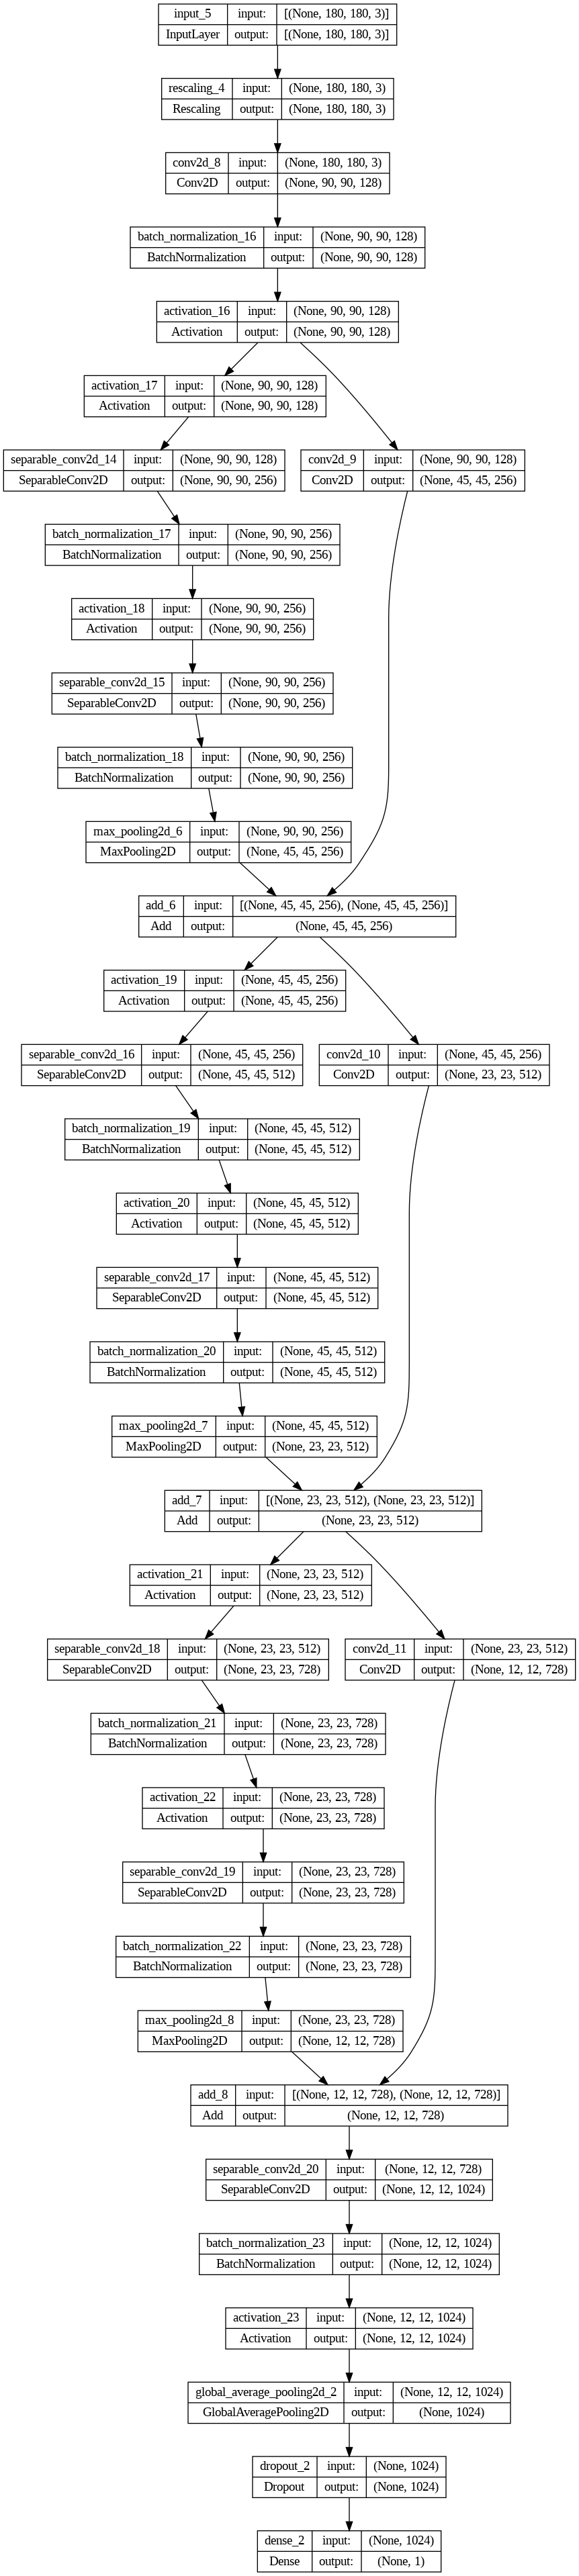

In [30]:
# Mô hình CNN
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [31]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
# Training model với số lần lập là echo
train_history = model.fit(
                        train_ds,
                        epochs=epochs,
                        callbacks=callbacks,
                        validation_data=val_ds,
)

Epoch 1/25
121/121 [==============================] - 192s 1s/step - loss: 0.6457 - accuracy: 0.6578 - val_loss: 0.6796 - val_accuracy: 0.6074
Epoch 2/25
121/121 [==============================] - 178s 1s/step - loss: 0.5379 - accuracy: 0.7378 - val_loss: 0.9602 - val_accuracy: 0.6074
Epoch 3/25
121/121 [==============================] - 177s 1s/step - loss: 0.4406 - accuracy: 0.8002 - val_loss: 1.1600 - val_accuracy: 0.6074
Epoch 4/25
121/121 [==============================] - 177s 1s/step - loss: 0.3443 - accuracy: 0.8516 - val_loss: 1.2824 - val_accuracy: 0.6074
Epoch 5/25
121/121 [==============================] - 178s 1s/step - loss: 0.2989 - accuracy: 0.8734 - val_loss: 0.6682 - val_accuracy: 0.6863
Epoch 6/25
121/121 [==============================] - 186s 2s/step - loss: 0.2556 - accuracy: 0.8929 - val_loss: 0.3371 - val_accuracy: 0.8389
Epoch 7/25
121/121 [==============================] - 178s 1s/step - loss: 0.2249 - accuracy: 0.9061 - val_loss: 0.6391 - val_accuracy: 0.7724

In [32]:
print(train_history.history)

{'loss': [0.6456524133682251, 0.5378831028938293, 0.44055789709091187, 0.3442942500114441, 0.2988613545894623, 0.25555261969566345, 0.2248561978340149, 0.2101883888244629, 0.18218177556991577, 0.1715593785047531, 0.15971124172210693, 0.15176992118358612, 0.13864000141620636, 0.13836540281772614, 0.12793393433094025, 0.11667144298553467, 0.12041468918323517, 0.1138070821762085, 0.10215861350297928, 0.10463167726993561, 0.0969003215432167, 0.09508006274700165, 0.08678072690963745, 0.08862809091806412, 0.08712510764598846], 'accuracy': [0.6577803492546082, 0.7378218770027161, 0.8001556992530823, 0.8515924215316772, 0.8733865022659302, 0.8929104208946228, 0.9060776829719543, 0.9145748019218445, 0.9255367517471313, 0.9307258129119873, 0.9342284202575684, 0.9376662373542786, 0.9449957609176636, 0.9433093070983887, 0.9484984278678894, 0.953882098197937, 0.9526496529579163, 0.9536226391792297, 0.957838773727417, 0.958617091178894, 0.961341381072998, 0.9627683758735657, 0.9645845293998718, 0.96

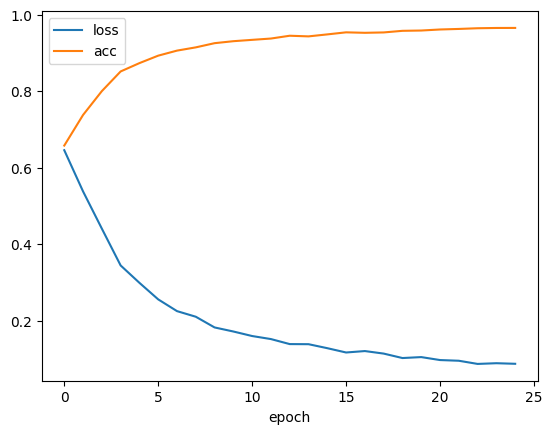

In [33]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['accuracy'])
plt.legend(['loss', 'acc'])
plt.xlabel('epoch')
plt.show()

In [34]:
# Lưu model vừa được train vào một tập tin
model.save("drive/MyDrive/Drive_thành_viên/BAN_CHỦ_NHIỆM/Danny/data _rain/dataset/trained_model.h5")

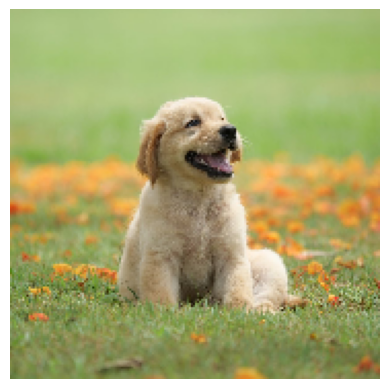

1/1 [==============================] - 0s 32ms/step
This image is 1.24% cat and 98.76% dog.


In [38]:
# Kiểm tra model vừa dducowj train

# Đường dẫn đến ảnh cần kiểm tra
image_path = "drive/MyDrive/Drive_thành_viên/BAN_CHỦ_NHIỆM/Danny/data _rain/Test/3.jpg"

# Đọc và hiển thị ảnh
img = keras.utils.load_img(image_path, target_size=image_size)
plt.imshow(img)
plt.axis('off')
plt.show()

# Chuẩn hóa và mở rộng chiều của ảnh
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Dự đoán và in kết quả
predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")